## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import pickle
import mlflow

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

2023-02-18 12:08:03.478164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carga do dado

Carregamento do dado e uso da coluna de datas como índice do DataFrame

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv', index_col=0, parse_dates=True)
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


## Tratamento do dado

Preenchimento de intervalos vazios no dado usando a interpolação dos valores. Era necessário o preenchimento correto para a decomposição da série temporal

In [4]:
df = df.resample('10T').mean().interpolate()

Uso de intervalos de 1 hora

In [5]:
df = df[5::6]

In [6]:
df.index

DatetimeIndex(['2009-01-01 01:00:00', '2009-01-01 02:00:00',
               '2009-01-01 03:00:00', '2009-01-01 04:00:00',
               '2009-01-01 05:00:00', '2009-01-01 06:00:00',
               '2009-01-01 07:00:00', '2009-01-01 08:00:00',
               '2009-01-01 09:00:00', '2009-01-01 10:00:00',
               ...
               '2016-12-31 15:00:00', '2016-12-31 16:00:00',
               '2016-12-31 17:00:00', '2016-12-31 18:00:00',
               '2016-12-31 19:00:00', '2016-12-31 20:00:00',
               '2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Date Time', length=70128, freq='60T')

## Análise e mais tratamento

Visualização das várias séries temporais presentes no dado

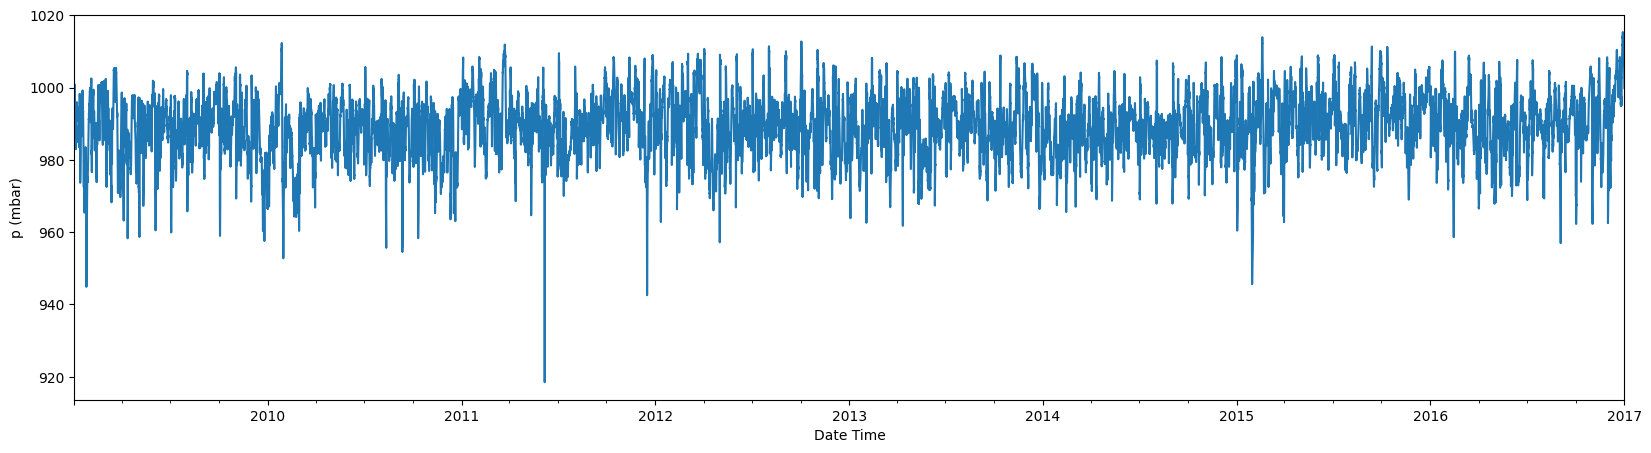

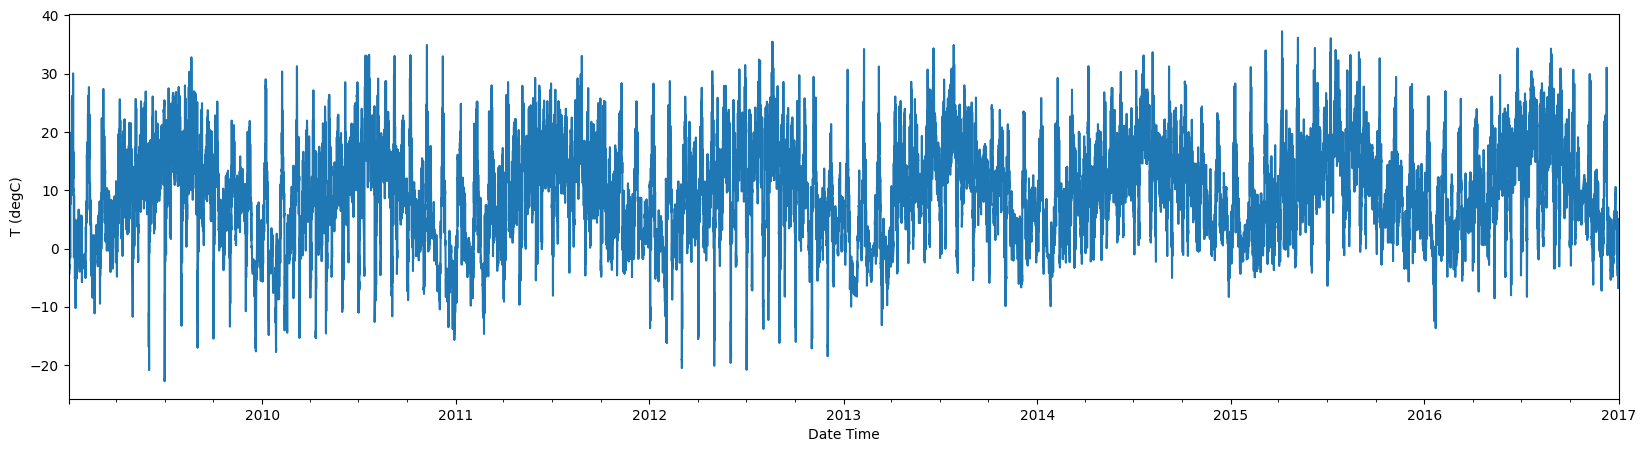

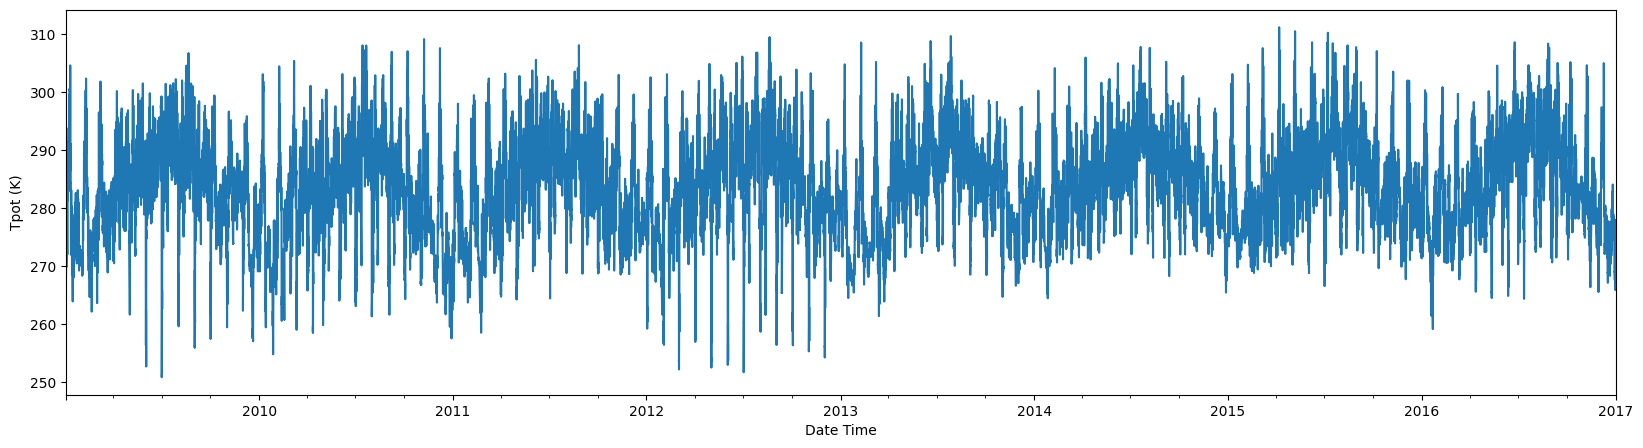

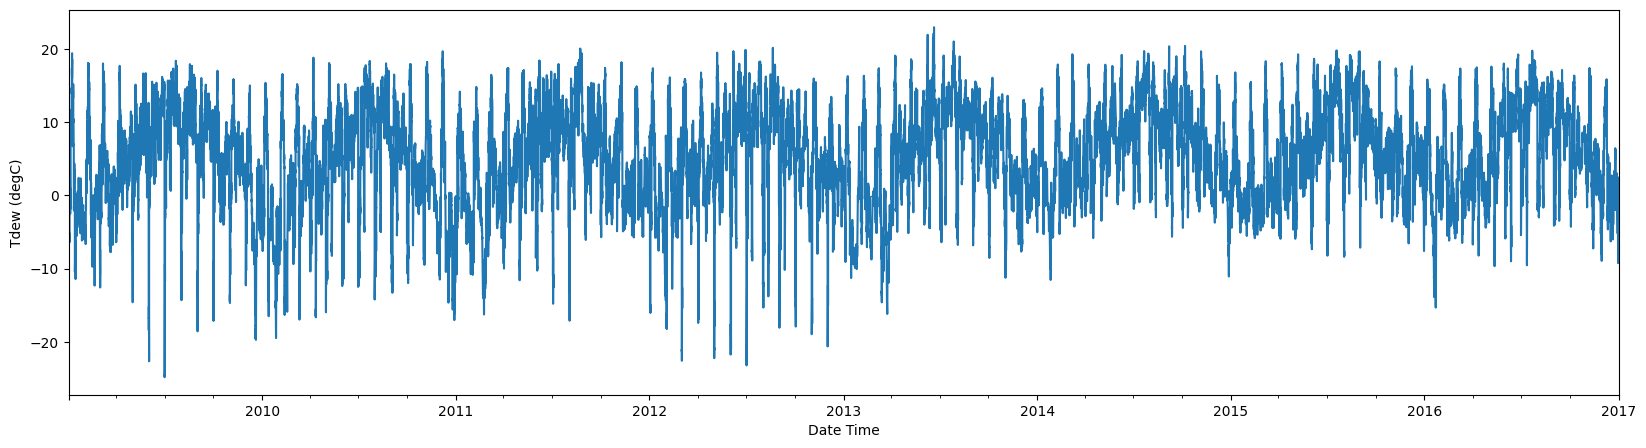

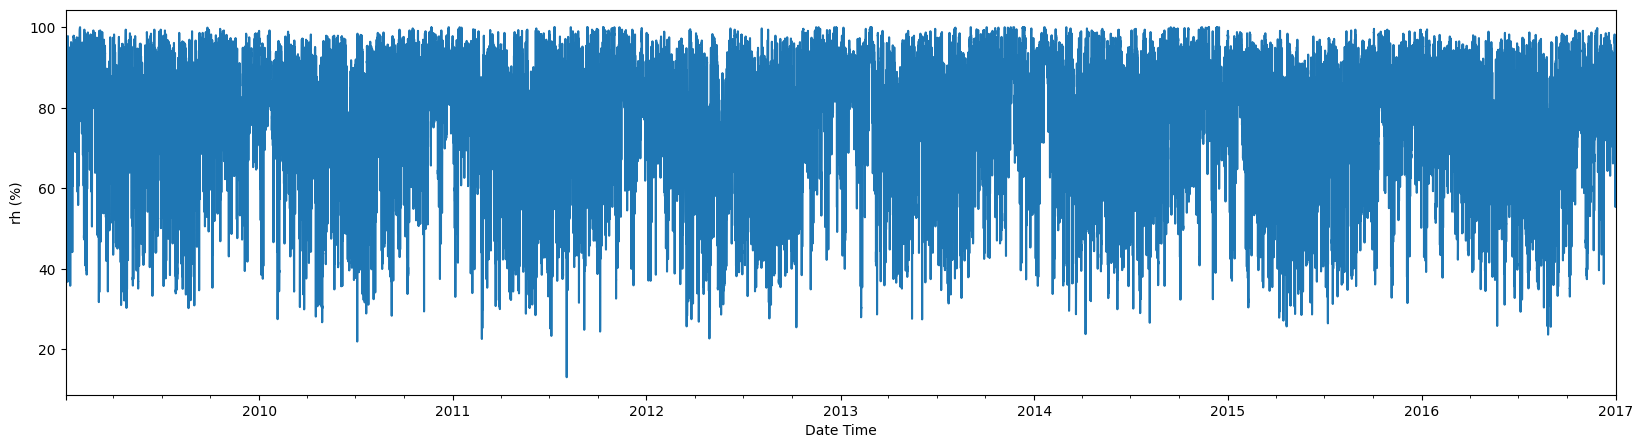

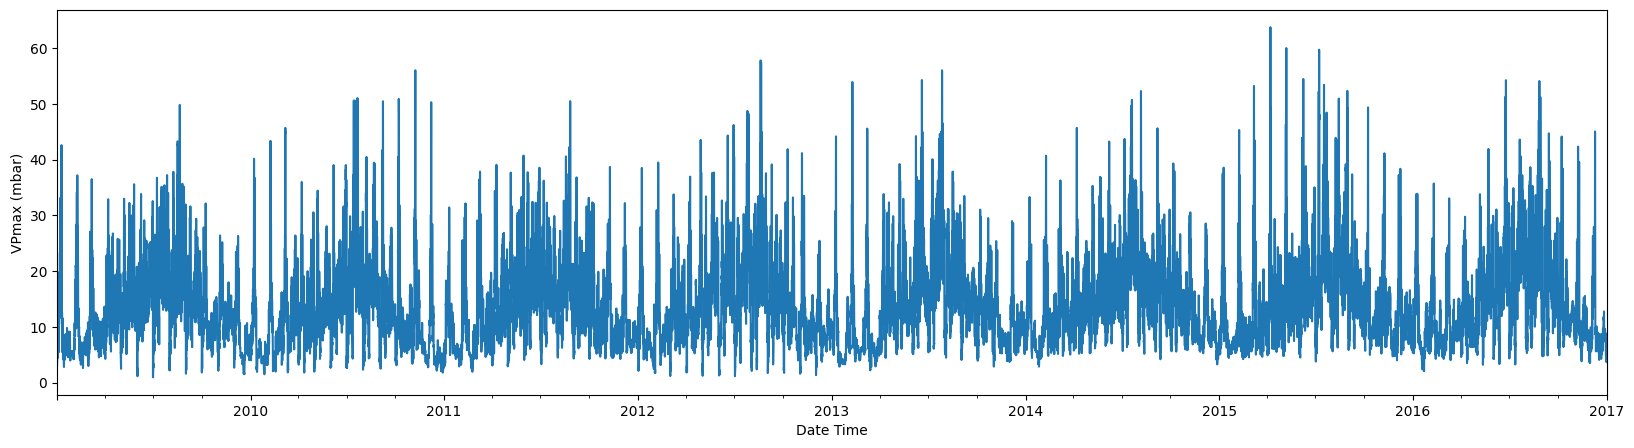

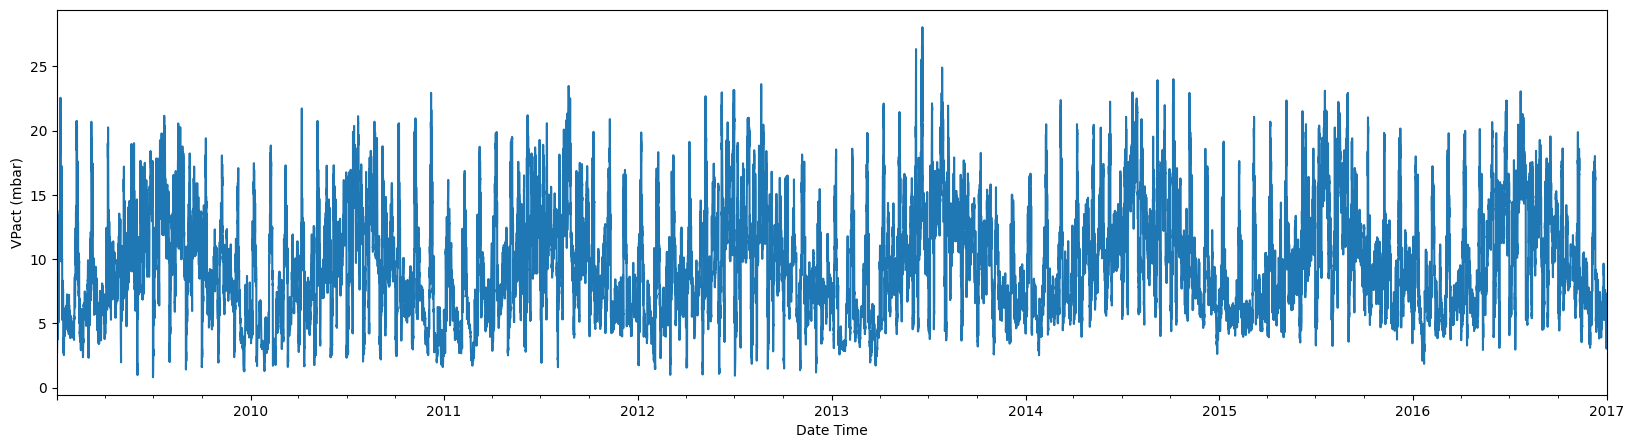

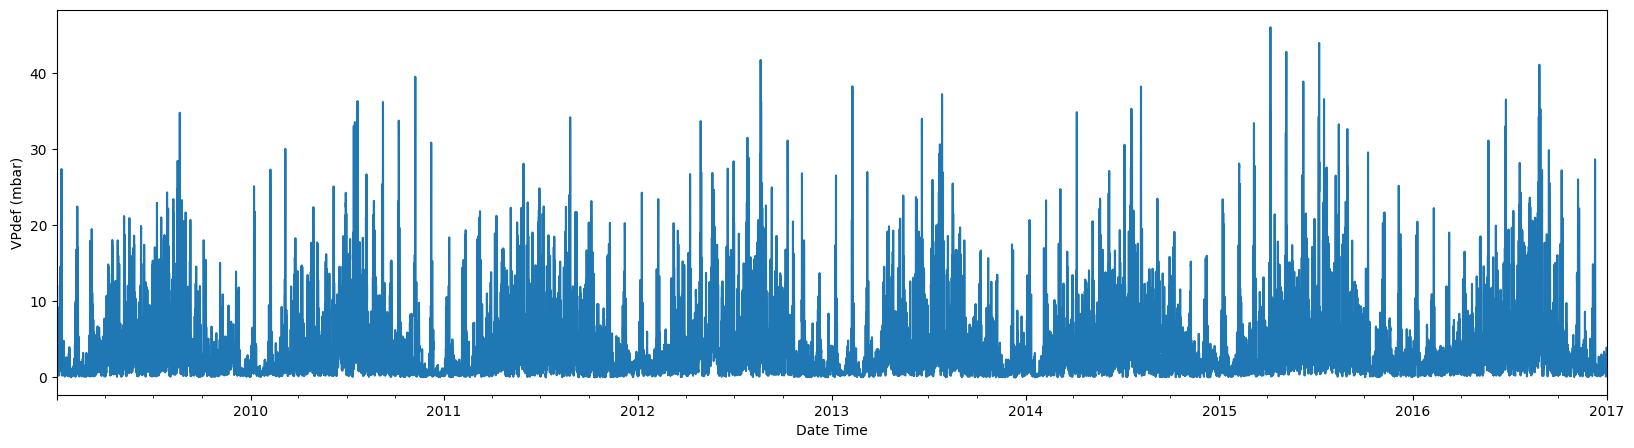

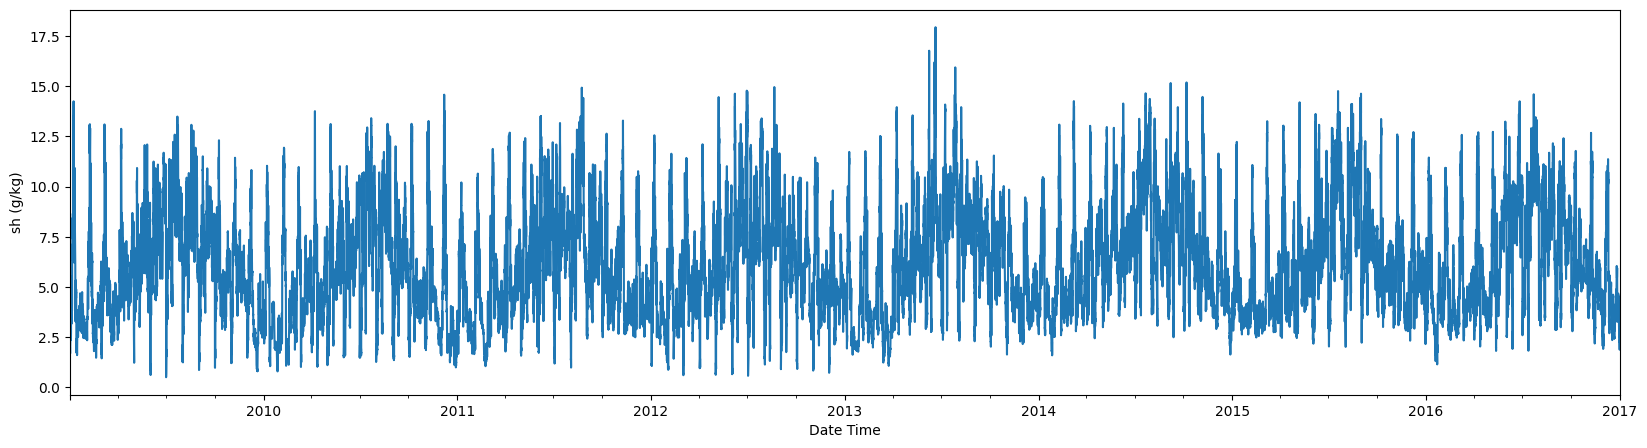

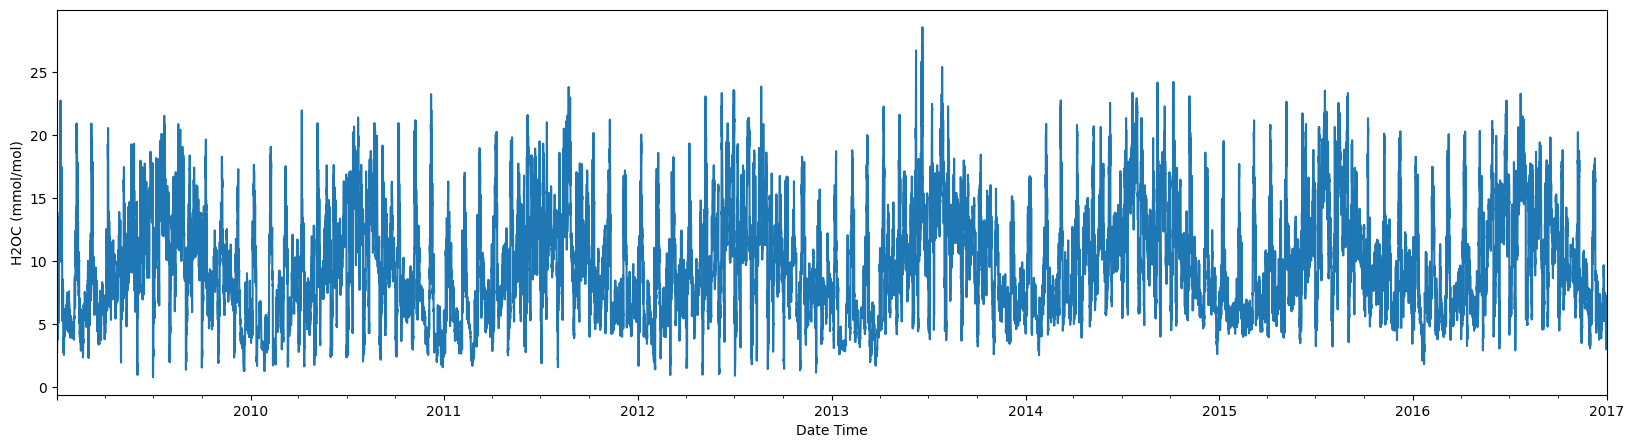

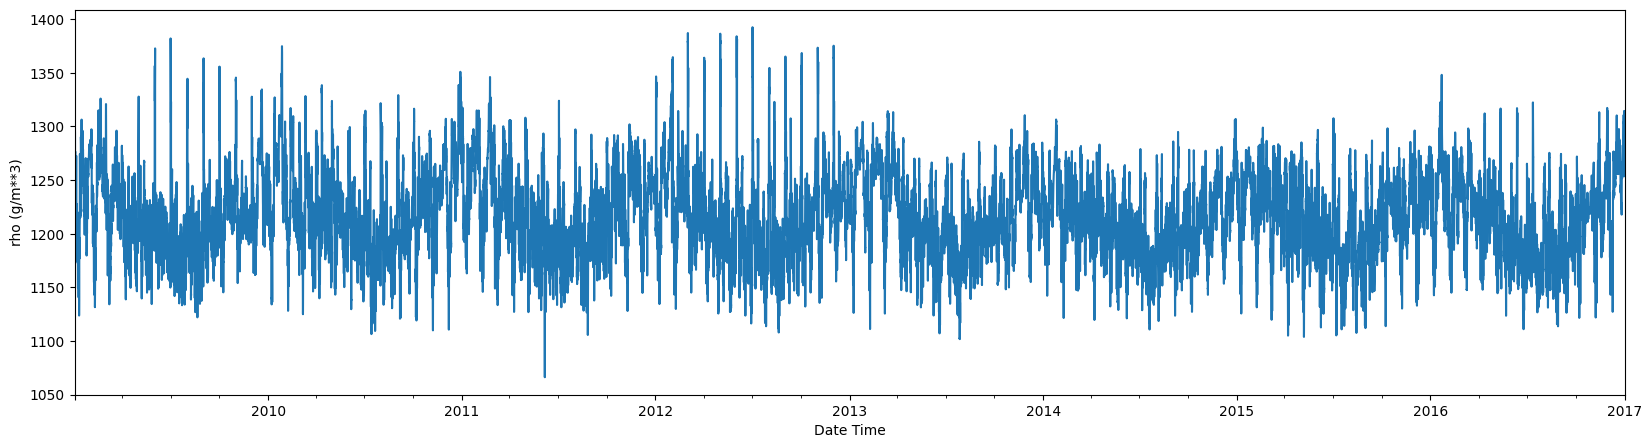

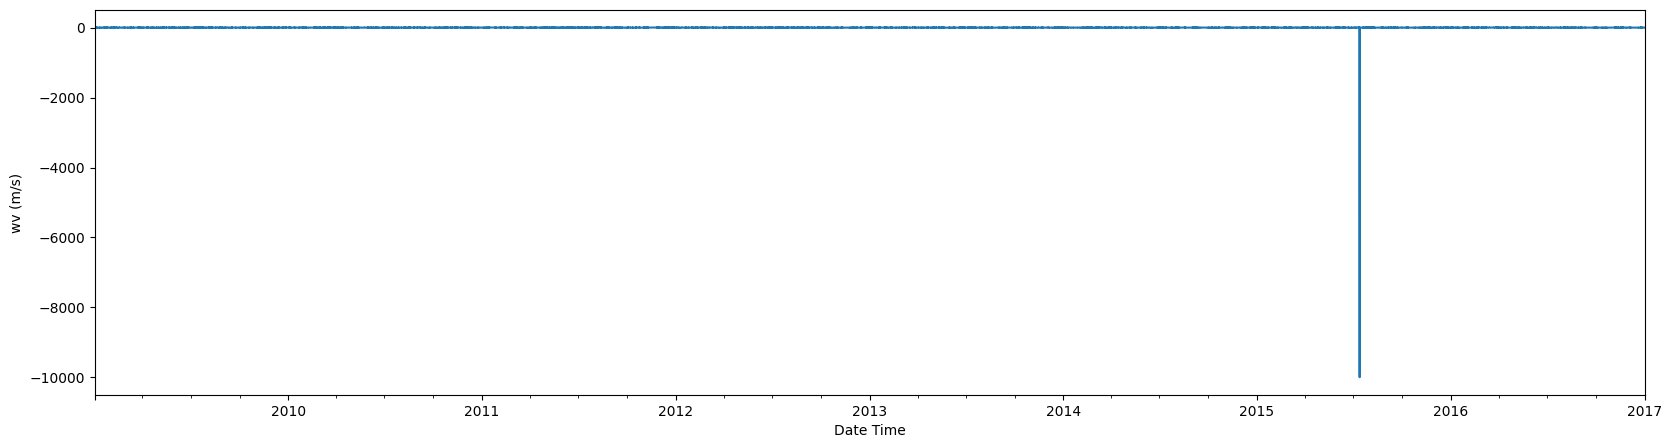

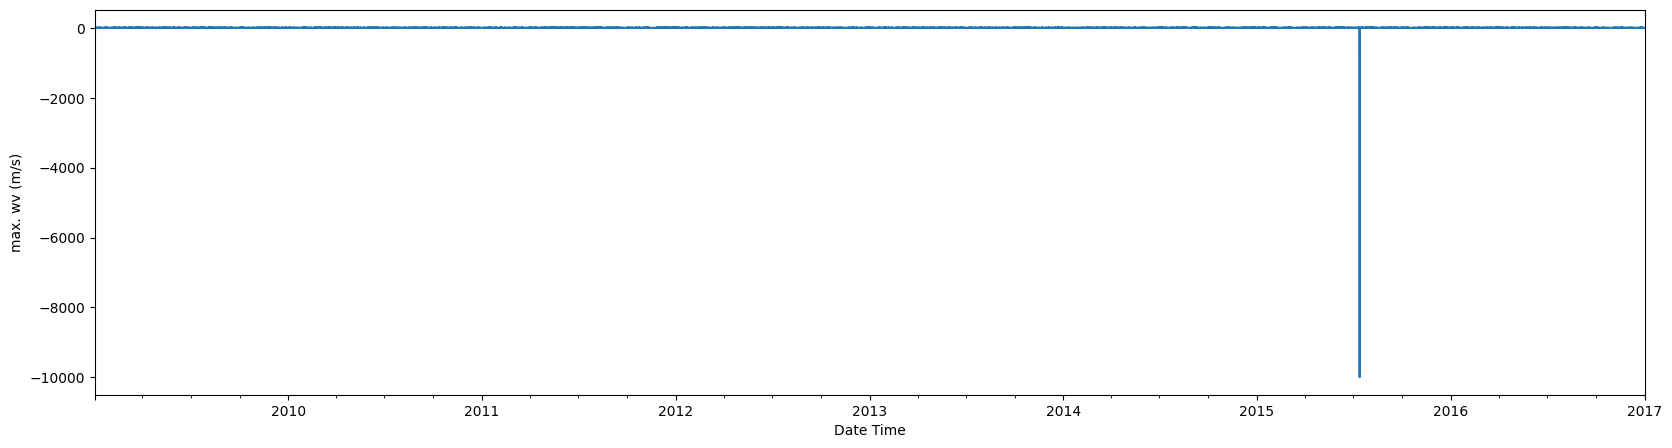

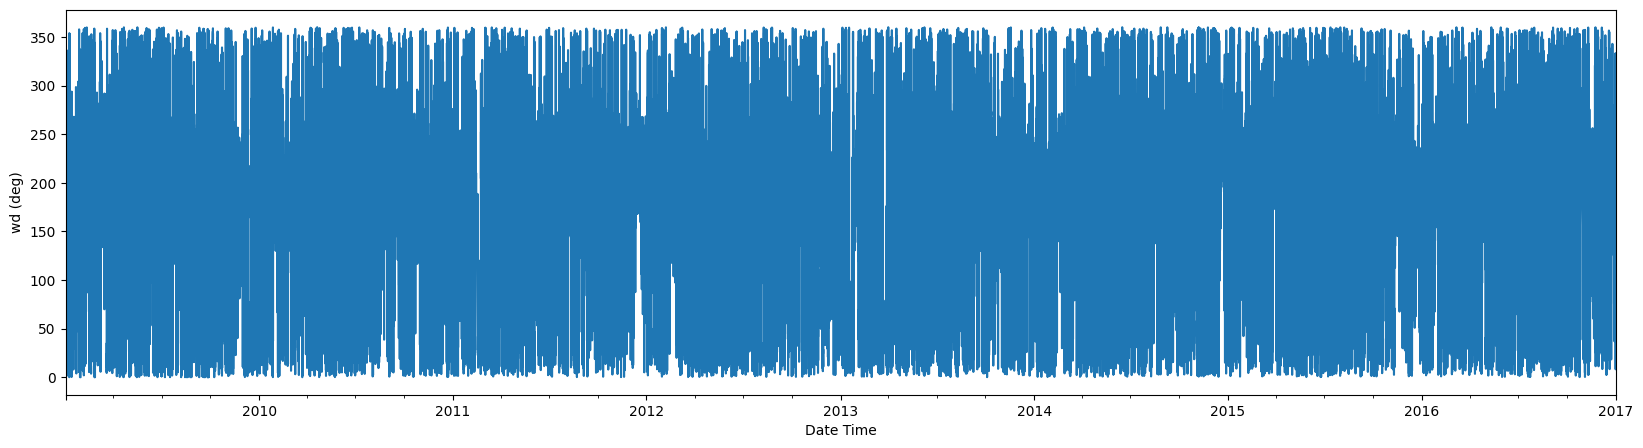

In [7]:
for col in df.columns:
    df[col].plot(figsize=(20, 5))
    plt.ylabel(col)
    plt.show()

Uso apenas da série "T (degC)" para o resto das análises e modelagem para predição

In [7]:
df = df[['T (degC)']]

Decomposição da série temporal

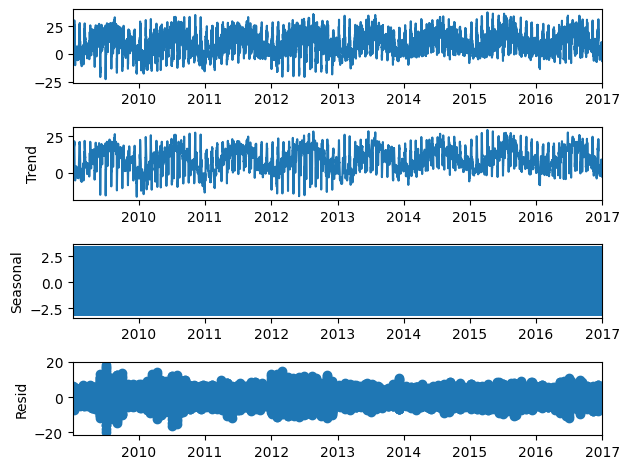

In [9]:
ets = seasonal_decompose(df, model='add')
ets.plot();

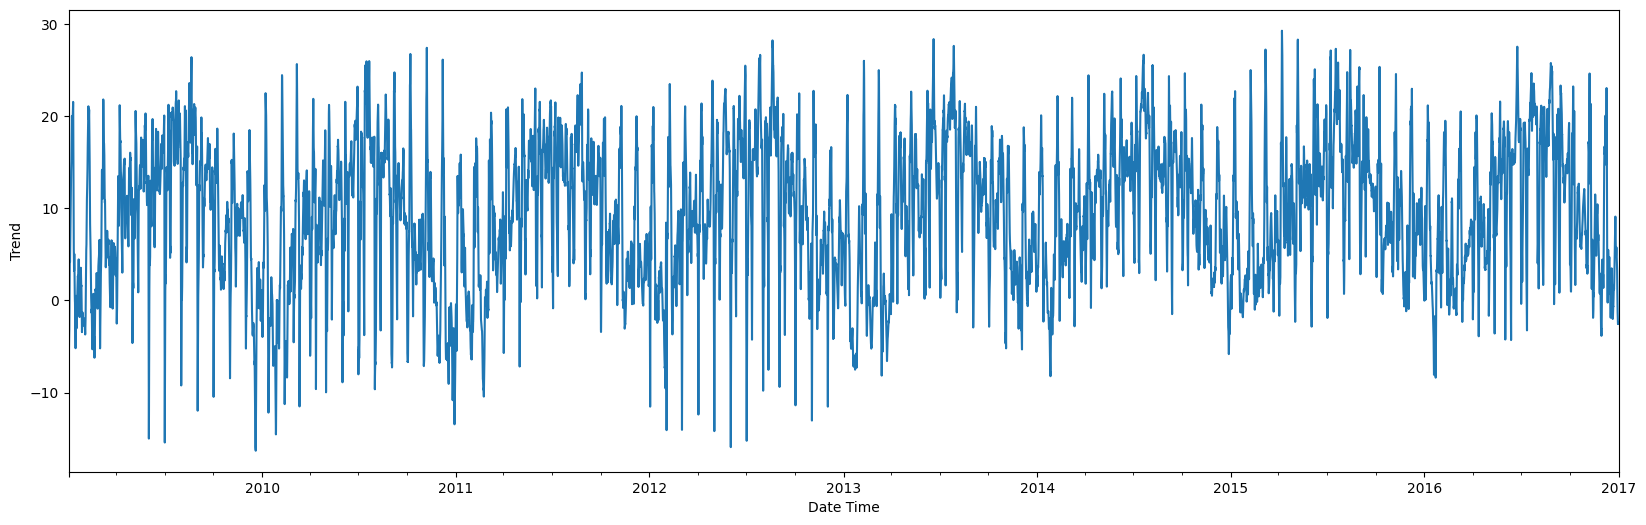

In [10]:
ets.trend.plot(figsize=(20, 6))
plt.ylabel('Trend');

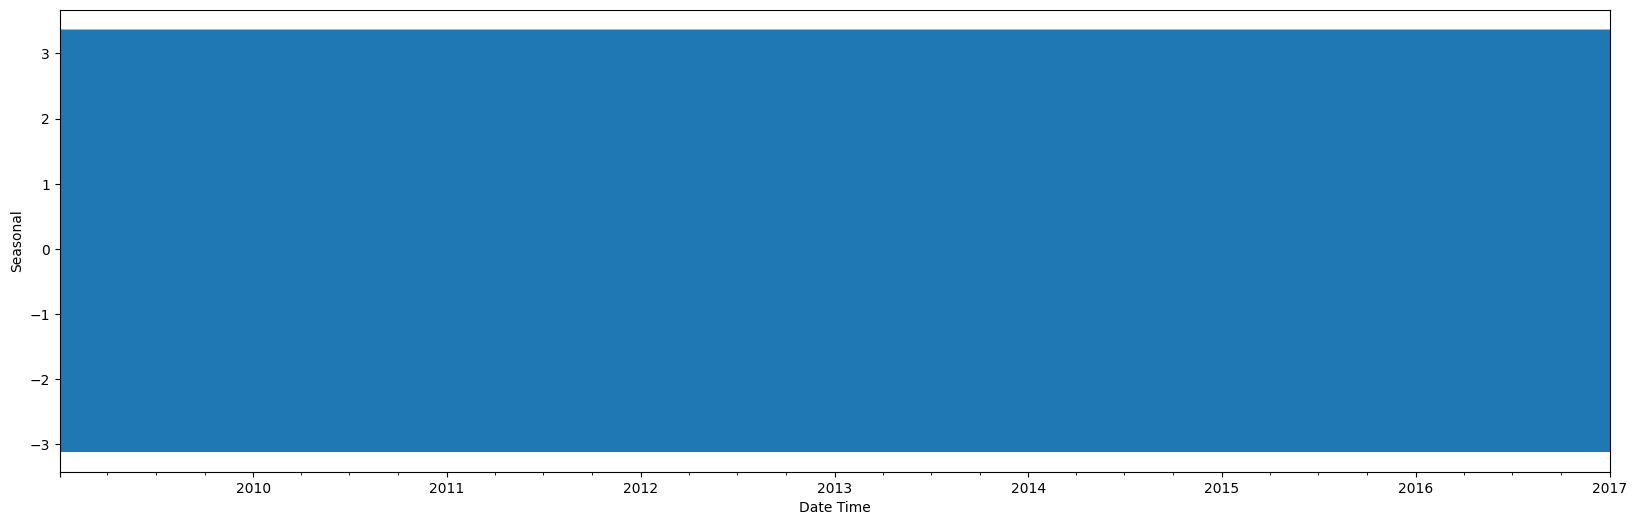

In [11]:
ets.seasonal.plot(figsize=(20, 6))
plt.ylabel('Seasonal');

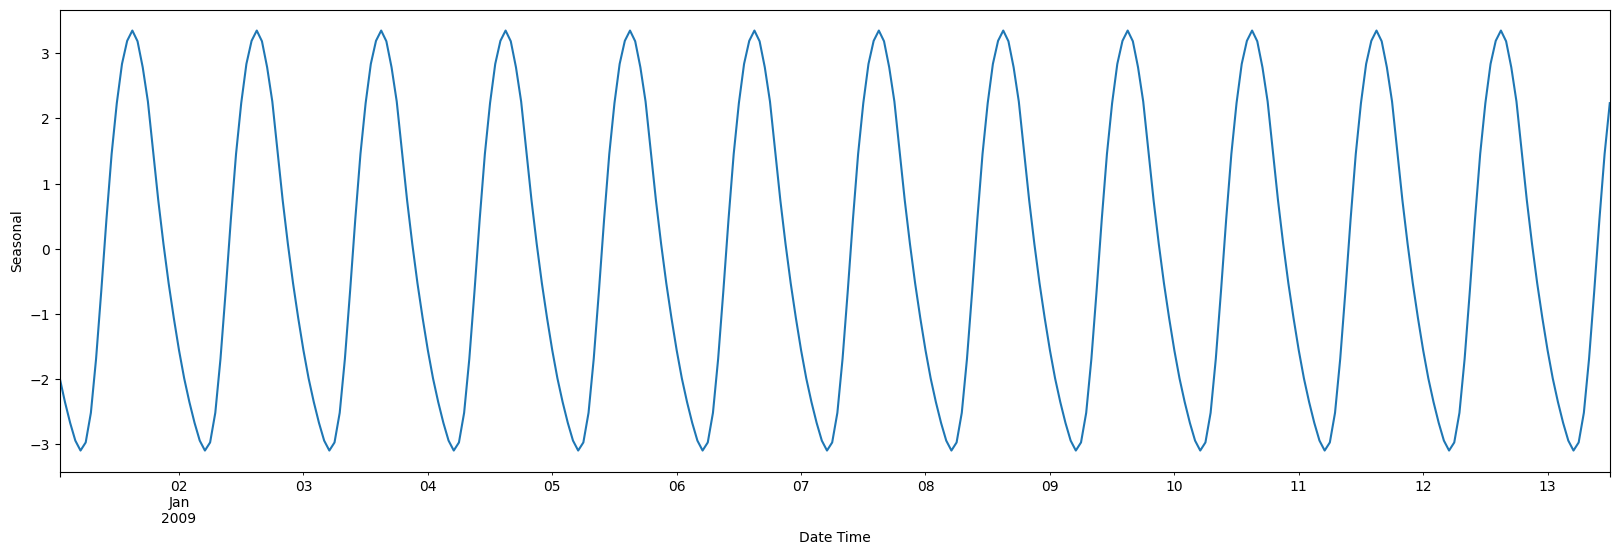

In [12]:
ets.seasonal[:300].plot(figsize=(20, 6))
plt.ylabel('Seasonal');

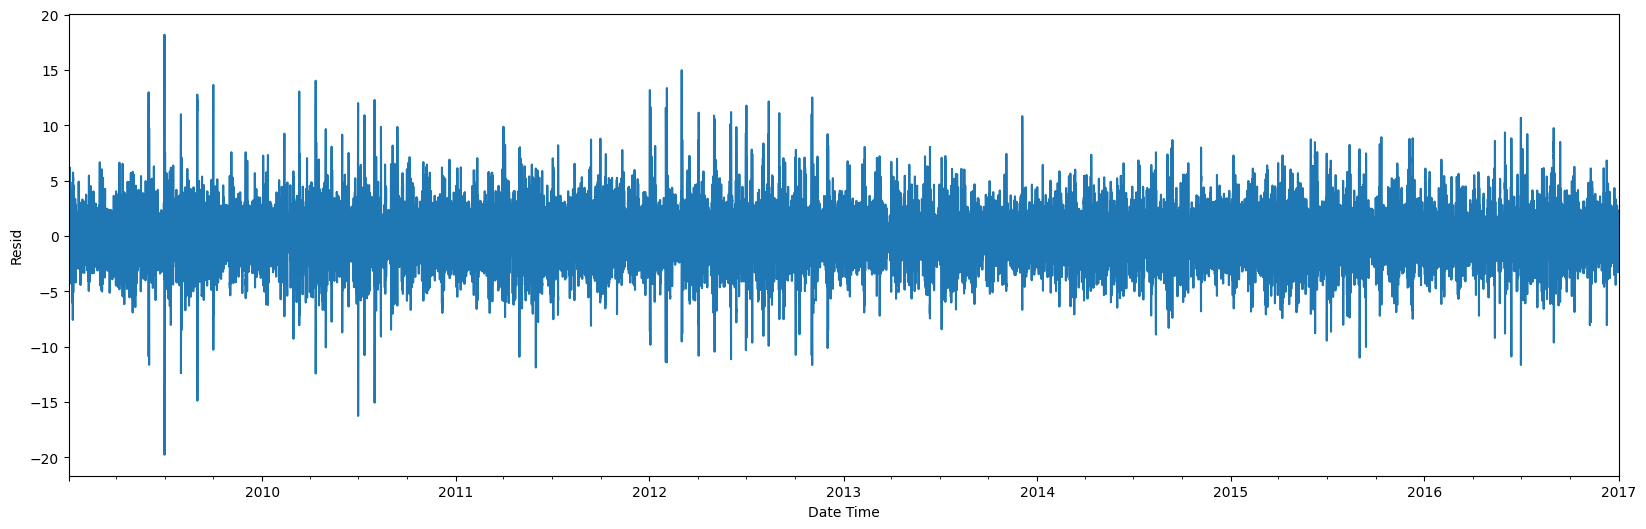

In [13]:
ets.resid.plot(figsize=(20, 6))
plt.ylabel('Resid');

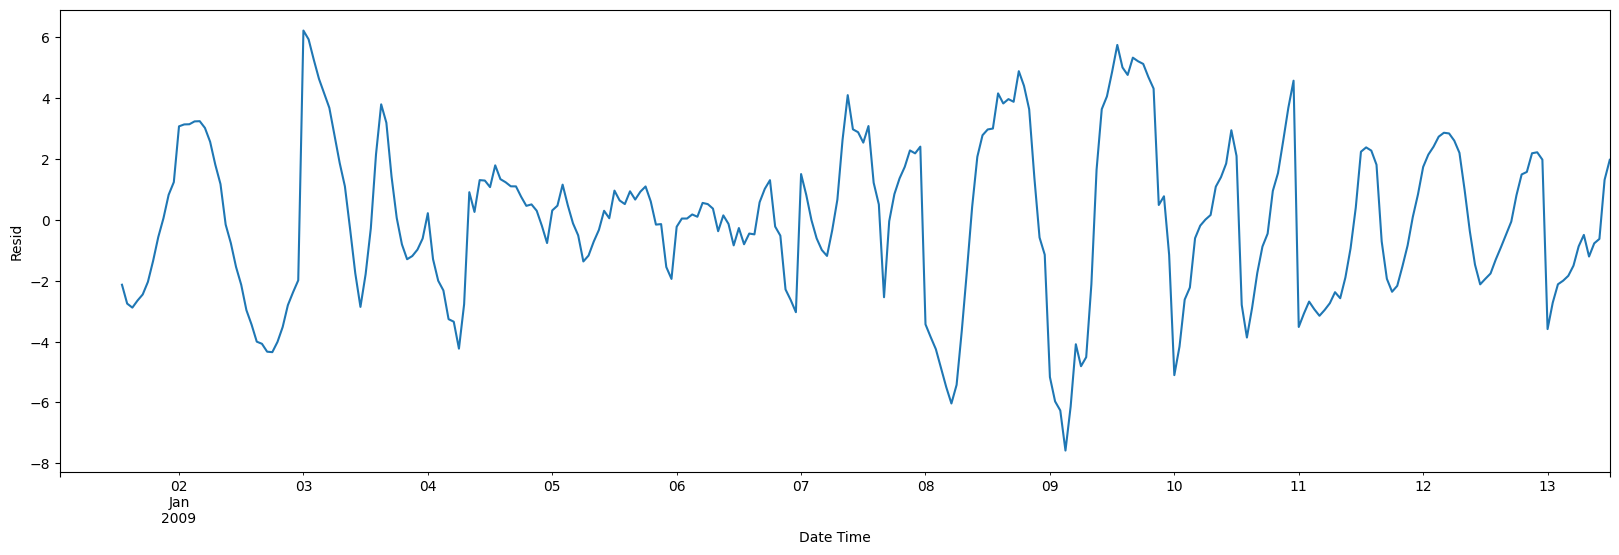

In [14]:
ets.resid[:300].plot(figsize=(20, 6))
plt.ylabel('Resid');

Visualizando mais de perto essa decomposição temporal, percebe-se 2 sazonalidades: uma diária e outra anual. Embora tenha apenas sido detectada a menor(diária) com este método

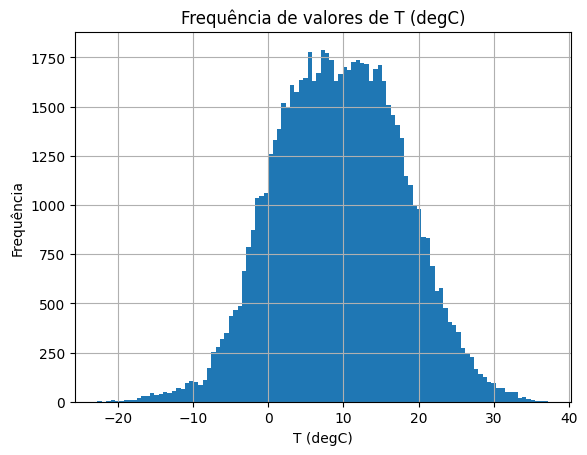

In [15]:
df['T (degC)'].hist(bins='auto')
plt.xlabel('T (degC)')
plt.ylabel('Frequência')
plt.title("Frequência de valores de T (degC)")
plt.show()

In [8]:
df.reset_index(inplace=True)

In [9]:
df.rename(columns={"Date Time": "date", "T (degC)": "y"}, inplace=True)

Redução do tamanho do dado para facilitar um pouco a execução

In [10]:
df = df.query("date >= '2014-01-01 00:00:00'")

Extração de features temporais para que o modelo possa se referenciar no tempo. </br>
d_semana = dia da semana</br>
d_mes = dia do mês</br>
d_ano = dia do ano</br>
ano = ano em que se encontra o valor</br>
hora_d = hora do dia

In [11]:
df['d_semana'] = df['date'].dt.strftime("%u").astype(int)
df['d_mes'] = df['date'].dt.strftime("%d").astype(int)
df['d_ano'] = df['date'].dt.strftime("%j").astype(int)
df['ano'] = df['date'].dt.strftime("%y").astype(int)
df['hora_d'] = df['date'].dt.strftime("%H").astype(int)

In [12]:
df

,date,y,d_semana,d_mes,d_ano,ano,hora_d
43823,2014-01-01 00:00:00,-0.12,3,1,1,14,0
43824,2014-01-01 01:00:00,0.64,3,1,1,14,1
43825,2014-01-01 02:00:00,1.10,3,1,1,14,2
43826,2014-01-01 03:00:00,1.97,3,1,1,14,3
43827,2014-01-01 04:00:00,2.36,3,1,1,14,4
...,...,...,...,...,...,...,...
70123,2016-12-31 20:00:00,-1.52,6,31,366,16,20
70124,2016-12-31 21:00:00,-3.09,6,31,366,16,21
70125,2016-12-31 22:00:00,-2.59,6,31,366,16,22
70126,2016-12-31 23:00:00,-3.76,6,31,366,16,23


Remoção da coluna date

In [13]:
df.drop(columns=['date'], inplace=True)

## Modelo
Uso de uma Random Forest

Definição de uma janela de móvel e da quantidade de valores a serem preditos no futuro.

In [15]:
window_size = 365*24 # Um ano
pred_size = 30*24  # Um mês

Definição do dado de treino e de teste

In [16]:
train_size = len(df) - pred_size
train = df[:train_size]
test = df[train_size - window_size:]

len(train), len(test)

(25585, 9480)

In [17]:
train

,y,d_semana,d_mes,d_ano,ano,hora_d
43823,-0.12,3,1,1,14,0
43824,0.64,3,1,1,14,1
43825,1.10,3,1,1,14,2
43826,1.97,3,1,1,14,3
43827,2.36,3,1,1,14,4
...,...,...,...,...,...,...
69403,3.39,4,1,336,16,20
69404,3.28,4,1,336,16,21
69405,3.01,4,1,336,16,22
69406,3.56,4,1,336,16,23


In [18]:
test

,y,d_semana,d_mes,d_ano,ano,hora_d
60648,4.95,4,3,337,15,1
60649,4.89,4,3,337,15,2
60650,4.64,4,3,337,15,3
60651,3.92,4,3,337,15,4
60652,3.48,4,3,337,15,5
...,...,...,...,...,...,...
70123,-1.52,6,31,366,16,20
70124,-3.09,6,31,366,16,21
70125,-2.59,6,31,366,16,22
70126,-3.76,6,31,366,16,23


Modelagem do dado
Ao final do processo, cada exemplo, ficará da seguinte forma: [365 * 24 valores (correspondentes a janela de valores), d_semana, d_mes, d_ano, ano, hora_d]. </br>
Cada exemplo terá como target, o ultimo instante da janela +5, sendo igual ou maior que 2, conforme solicitado pelo desafio

In [19]:
def create_dataset(x, y, window_size=1, periods_ahead=2):
    periods_ahead -= 1
    xs = []
    ys = []
    for i in range(len(x) - window_size - periods_ahead):
        #if 
        v = x.iloc[i: i + window_size, 0].to_numpy()
        v = np.append(v, x.iloc[i + window_size, 1])#d_semana
        v = np.append(v, x.iloc[i + window_size, 2])#d_mes
        v = np.append(v, x.iloc[i + window_size, 3])#d_ano
        v = np.append(v, x.iloc[i + window_size, 4])#ano
        v = np.append(v, x.iloc[i + window_size, 5])#hora_d
        xs.append(v)
        ys.append(y.iloc[i + window_size + periods_ahead])
    return np.array(xs), np.array(ys)

In [20]:
periods_ahead = 5
x_train, y_train = create_dataset(train, train['y'], window_size, periods_ahead)
x_test, y_test = create_dataset(test, test['y'], window_size, periods_ahead)

len(x_train), len(x_test)

(16821, 716)

In [21]:
x_train.shape, y_train.shape

((16821, 8765), (16821,))

In [22]:
x_test.shape, y_test.shape

((716, 8765), (716,))

In [22]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

Execução do algoritmo Random Forest

In [23]:
mlflow.set_experiment("Random Forest")
#falta rodar dnv
n_estimators_list = [100, 200]#, , 300
criterion_list = ['squared_error']#'friedman_mse', 
min_samples_split_list = [2, 4, 6, 8]
min_samples_leaf_list = [1, 2, 3, 4]
max_features_list = ['sqrt', 'log2', 0.25, 0.5, 0.75, 1]
bootstrap_list = [True, False]

for n_estimators in n_estimators_list:
    for criterion in criterion_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                for max_features in max_features_list:
                    for bootstrap in bootstrap_list:
                        with mlflow.start_run():
                            model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, 
                                                          min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                                          max_features=max_features, bootstrap=bootstrap, n_jobs=8)
                            
                            model.fit(x_train, y_train)
                            y_pred = model.predict(x_test)
                            
                            params = {'n_estimators': n_estimators, 'criterion': criterion, 'min_samples_leaf': min_samples_leaf, 
                                      'min_samples_split': min_samples_split, 'max_features': max_features, 'bootstrap': bootstrap}
                            mlflow.log_params(params)
                            metrics = {'rmse': mean_squared_error(y_test, y_pred) ** (1/2), 
                                       'mae': mean_absolute_error(y_test, y_pred),
                                       'r2': r2_score(y_test, y_pred)}
                            mlflow.log_metrics(metrics)
                        mlflow.end_run()

In [ ]:
mlflow.set_experiment("Ada Boost")
n_estimators_list = [50, 100, 150, 200, 250]
estimator_list = [DecisionTreeRegressor(max_depth=i) for i in range(1, 6)]
learning_rate_list = [0.01, 0.1, 0.25, 0.5, 0.75, 1]
loss_list = ['linear', 'square', 'exponential']

for n_estimators in n_estimators_list:
    for estimator in estimator_list:
        for learning_rate in learning_rate_list:
            for loss in loss_list:
                with mlflow.start_run():
                    model = AdaBoostRegressor(n_estimators=n_estimators, base_estimator=estimator, 
                                                  learning_rate=learning_rate, loss=loss)

                    model.fit(x_train, y_train)
                    y_pred = model.predict(x_test)

                    params = {'n_estimators': n_estimators, 'base_estimator': estimator, 'learning_rate': learning_rate, 
                              'loss': loss}
                    mlflow.log_params(params)
                    metrics = {'rmse': mean_squared_error(y_test, y_pred) ** (1/2), 
                               'mae': mean_absolute_error(y_test, y_pred),
                               'r2': r2_score(y_test, y_pred)}
                    mlflow.log_metrics(metrics)
                mlflow.end_run()

2023/02/14 09:03:12 INFO mlflow.tracking.fluent: Experiment with name 'Ada Boost' does not exist. Creating a new experiment.


In [ ]:
mlflow.set_experiment("Gradient Boosting")
n_estimators_list = [100, 200, 300]
criterion_list = ['friedman_mse', 'squared_error']
min_samples_split_list = [2, 4, 6, 8]
loss_list = ['linear', 'square', 'exponential']
min_samples_leaf_list = [1, 2, 3, 4, 5, 6], 
max_features_list = ['sqrt', 'log2', 0.25, 0.5, 0.75, 1]
learning_rate_list = [0.01, 0.1, 0.25, 0.5, 0.75, 1]

for n_estimators in n_estimators_list:
    for estimator in criterion_list:
        for min_samples_split in min_samples_split_list:
            for loss in loss_list:
                for min_samples_leaf in min_samples_leaf_list:
                    for max_features in max_features_list:
                        for learning_rate in learning_rate_list:
                            with mlflow.start_run():
                                model = GradientBoostingRegressor(n_estimators=n_estimators, criterion=criterion, 
                                                                  min_samples_split=min_samples_split, learning_rate=learning_rate, loss=loss,
                                                                  min_samples_leaf=min_samples_leaf, max_features=max_features)

                                model.fit(x_train, y_train)
                                y_pred = model.predict(x_test)

                                params = {'n_estimators': n_estimators, 'criterion': criterion, 'min_samples_split': min_samples_split, 
                                          'loss': loss, 'learning_rate': learning_rate, 'min_samples_leaf': min_samples_leaf, 'max_features':max_features}
                                mlflow.log_params(params)
                                metrics = {'rmse': mean_squared_error(y_test, y_pred) ** (1/2), 
                                           'mae': mean_absolute_error(y_test, y_pred),
                                           'r2': r2_score(y_test, y_pred)}
                                mlflow.log_metrics(metrics)
                            mlflow.end_run()

Melhor modelo

In [23]:
model = RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_features=0.25, min_samples_leaf=1, 
                              min_samples_split=4, n_estimators=200, n_jobs=10).fit(x_train, y_train)

Predição

In [28]:
preds = model.predict(x_test)

Comparação dos valores preditos com os reais

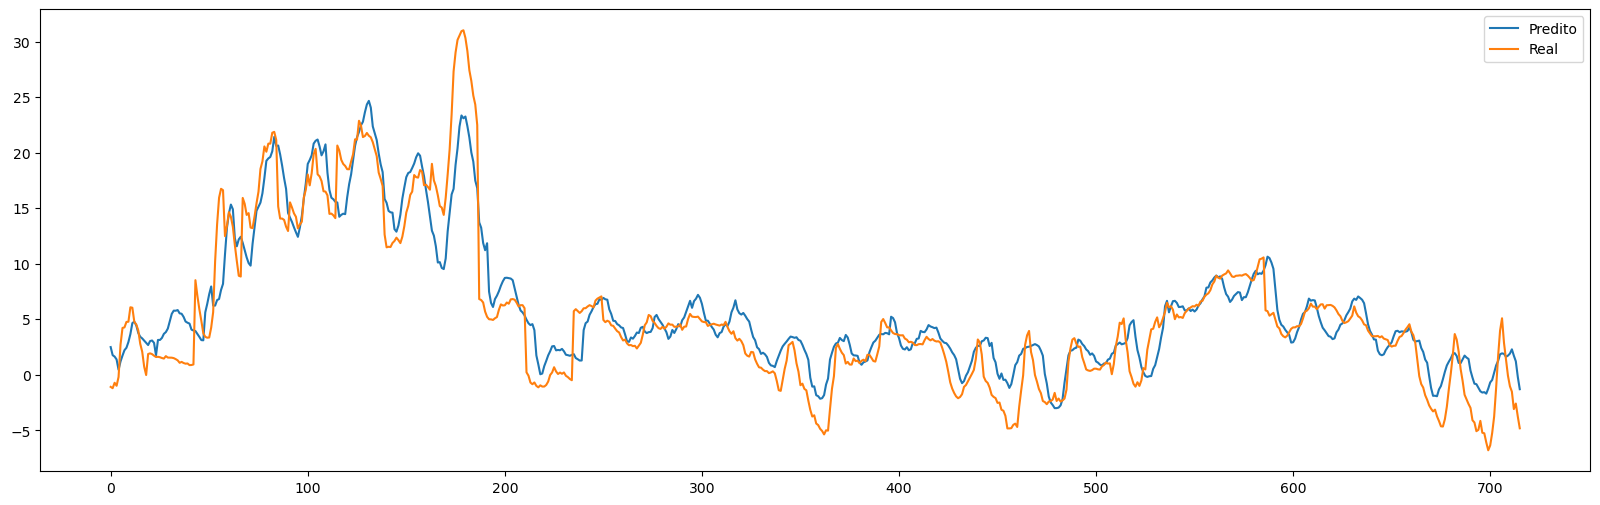

In [29]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(preds)), preds, label="Predito")
plt.plot(range(len(y_test)), y_test, label="Real")
plt.legend()
plt.show()

Métricas obtidas

In [30]:
rmse = mean_squared_error(y_test, preds) ** (1/2)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f'RMSE={rmse}')
print(f'MAE={mae}')
print(f'R2={r2}')

RMSE=2.655833182827026
MAE=2.0113534609314323
R2=0.8547618386522392


Text(0, 0.5, 'Predito')

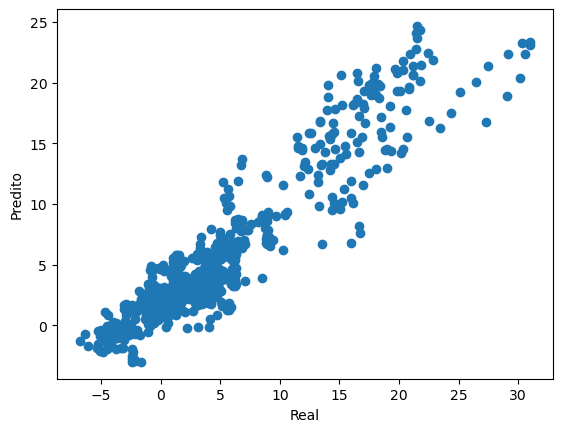

In [31]:
plt.scatter(y_test, preds)

plt.xlabel('Real')
plt.ylabel('Predito')

## Modelo 2
Uso de RNA

Normalização dos datasets de teste e de treino (x e y), necessário para modelo de redes neurais

In [74]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [77]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

Construção do modelo

In [82]:
def get_RNA_model(n_inputs):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_inputs, 1)))
    #model.add(LSTM(100, activation='relu')
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    return model

model = Execução do modelo

In [92]:
model = get_RNA_model(x_train.shape[1])
history = model.fit(x=x_train_scaled, y=y_train_scaled, epochs=12, batch_size=128)

with open('lstm_5.pkl', 'wb') as f:
    pickle.dump(model, f)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
132/132 [==============================] - 1005s 8s/step - loss: 0.0265
Epoch 2/12
132/132 [==============================] - 1065s 8s/step - loss: 0.0108
Epoch 3/12
132/132 [==============================] - 861s 7s/step - loss: 0.0097
Epoch 4/12
132/132 [==============================] - 841s 6s/step - loss: 0.0091
Epoch 5/12
132/132 [==============================] - 829s 6s/step - loss: 0.0083
Epoch 6/12
132/132 [==============

In [ ]:
with open('lstm_5.pkl', 'rb') as f:
    model = pickle.load(f)

Predição

In [93]:
preds = model.predict(x_test_scaled)

23/23 [==============================] - 34s 1s/step


Comparação dos valores preditos com os reais

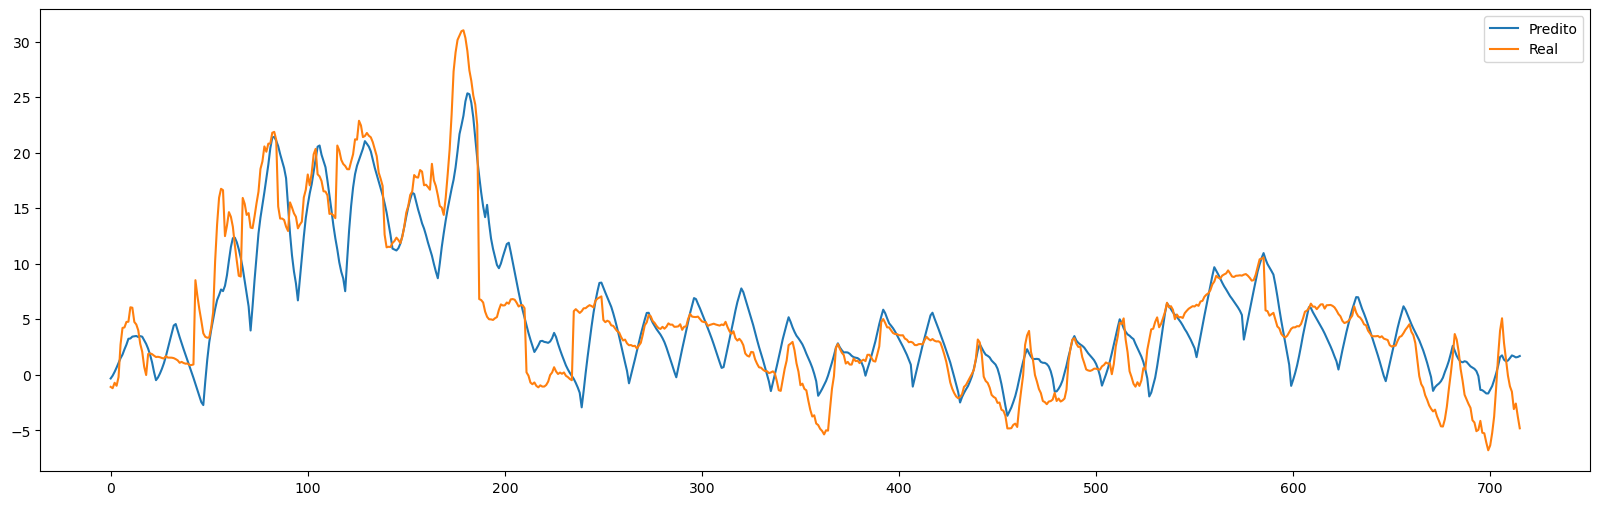

In [94]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(preds)), y_scaler.inverse_transform(preds.reshape(-1, 1)), label="Predito")
plt.plot(range(len(y_test_scaled)), y_scaler.inverse_transform(y_test_scaled), label="Real")
plt.legend()
plt.show()

Métricas obtidas

In [95]:
rmse = mean_squared_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(preds.reshape(-1, 1))) ** (1/2)
mae = mean_absolute_error(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(preds.reshape(-1, 1)))
r2 = r2_score(y_test, preds)
print(f'RMSE={rmse}')
print(f'MAE={mae}')
print(f'R2={r2}')

RMSE=3.270322796899845
MAE=2.4594587331339093
R2=-0.4714435994618582


Text(0, 0.5, 'Predito')

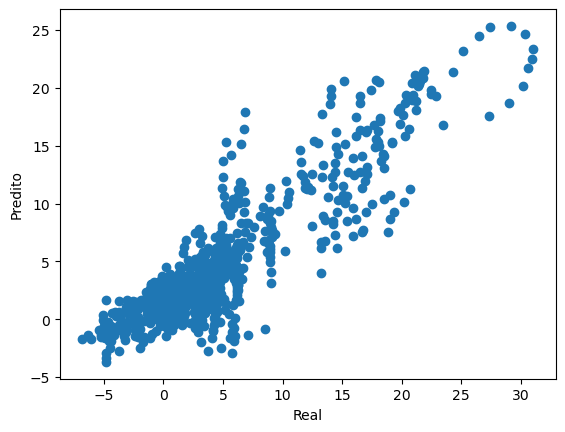

In [98]:
plt.scatter(y_scaler.inverse_transform(y_test_scaled), y_scaler.inverse_transform(preds.reshape(-1, 1)))

plt.xlabel('Real')
plt.ylabel('Predito')